In [1]:
# Library of my own functions
import sys
sys.path.append("../../../src/")
import my_functions

# Libraries to deal with dataframes, vectors and formats
import pandas as pd
import numpy as np
import pickle as pkl

# sklearn to do Grid Search & ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score 

# Imbalanced Learn
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Plotting libraries to understand the models
import matplotlib.pyplot as plt
import seaborn as sns
import logging
logging.getLogger().setLevel(logging.CRITICAL) # Avoids no critical warnings
plt.rcParams['figure.figsize'] = [20, 4] # Change figure size of the cell of the notebook

# 1. Train Model

##  1.1 Create Features and Target

In [2]:
df = pd.read_csv("../../../data/pima/preprocess/stratified_standard_scaler.csv", index_col="index")

# Split the data into train and validation sets
df_training, df_validation = df[df["split"] =="train"], df[df["split"] =="test"]
X_train, X_validation = df_training.iloc[:, 0:8], df_validation.iloc[:, 0:8]
y_train, y_validation = df_training["Outcome"], df_validation["Outcome"]

# Divide all data for predictions
X_all = df.iloc[:, 0:8]

## 1.2 Create SMOTE

In [3]:
sm = SMOTE(random_state=1)

X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [4]:
ad = ADASYN(random_state=1)
X_adasyn, y_adasyn = ad.fit_resample(X_train, y_train)

In [5]:
bl = BorderlineSMOTE(random_state=1)
X_borderline, y_borderline = bl.fit_resample(X_train, y_train)

In [6]:
svm = SVMSMOTE(random_state=1)
X_svm, y_svm = svm.fit_resample(X_train, y_train)

In [7]:
ros = RandomOverSampler(random_state=1)
X_ros, y_ros = ros.fit_resample(X_train, y_train)


In [8]:
under = RandomUnderSampler(random_state=1)
X_under, y_under = under.fit_resample(X_train, y_train)

In [10]:
data_to_train = [(X_train, y_train, "STANDARD"), (X_smote, y_smote, "SMOTE"), (X_adasyn, y_adasyn, "ADASYN"), (X_borderline, y_borderline, "BORDERLINE"), (X_svm, y_svm, "SVM"), (X_ros, y_ros, "RANDOM"), (X_under, y_under, "UNDER")] 

## 2.2 Logistic Regression 

#### 2.2.1  Train

In [13]:
for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]

    path = "../../../results/pima/Training/stratified_standard_scaler/log_reg_" + name + ".csv"

    parameters = {
        'C'       : np.linspace(0.001,2,500),
    }

    name_logreg = LogisticRegression(random_state=1)

    clf_logreg = GridSearchCV(name_logreg,                    # model
                    param_grid = parameters,   # hyperparameters
                    scoring="f1_weighted",        # metric for scoring
                    cv=10,
                    return_train_score=True)      

    clf_logreg.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(clf_logreg.cv_results_)
    df.to_csv(path)

    # Save Model
    log_reg_best = clf_logreg.best_estimator_ # Best Model

    path = "../../../models/pima/stratified_standard_scaler/logistic_regression_" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(log_reg_best,f)

### 2.2.2 View Results

In [107]:
df = pd.DataFrame()

for i in data_to_train:

    name = i[2]
    path = "../../../results/pima/Training/stratified_standard_scaler/log_reg_" + name + ".csv"

    df_loop = pd.read_csv(path, index_col= False)
    df_loop["oversampling_technique"] = name

    df = df.append(df_loop)

In [108]:
df = df[["param_C", "mean_test_score", "mean_train_score", "oversampling_technique"]]

df = pd.melt(df, id_vars=['param_C', "oversampling_technique"], value_vars=['mean_test_score', 'mean_train_score'], value_name="f1-weighted", var_name="split")

In [109]:
df.head(20)

,param_C,oversampling_technique,split,f1-weighted
0,0.001000,STANDARD,mean_test_score,0.520408
1,0.006004,STANDARD,mean_test_score,0.719913
2,0.011008,STANDARD,mean_test_score,0.739884
3,0.016012,STANDARD,mean_test_score,0.743825
4,0.021016,STANDARD,mean_test_score,0.749983
5,0.026020,STANDARD,mean_test_score,0.748987
6,0.031024,STANDARD,mean_test_score,0.752927
7,0.036028,STANDARD,mean_test_score,0.751504
8,0.041032,STANDARD,mean_test_score,0.751504
9,0.046036,STANDARD,mean_test_score,0.751591


In [112]:
def plot_logreg_hyper(df, oversampling_technique):
    sns.lineplot(data=df, x="param_C",y="f1-weighted", hue="split",lw=5)
    plt.xlabel("Hyperparameter C", weight='bold', size=10)
    plt.ylabel("F1 weighted", weight='bold', size=10)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title(oversampling_technique, weight='bold', size=16)

    # Set legend
    leg = plt.legend(fontsize="small")
    leg.get_lines()[0].set_linewidth(5)
    leg.get_lines()[1].set_linewidth(5)

    # Plot vertical dotted line
    plt.axvline(x=0.018, color='gray', linestyle='dotted', linewidth=5)
    # plt.annotate('No improvements from here', xy =(0.019, 0.75),
    #                xytext =(0.03, 0.65), fontsize=13, 
    #                arrowprops = dict(facecolor ='black',
    #                                shrink = 0.05),)


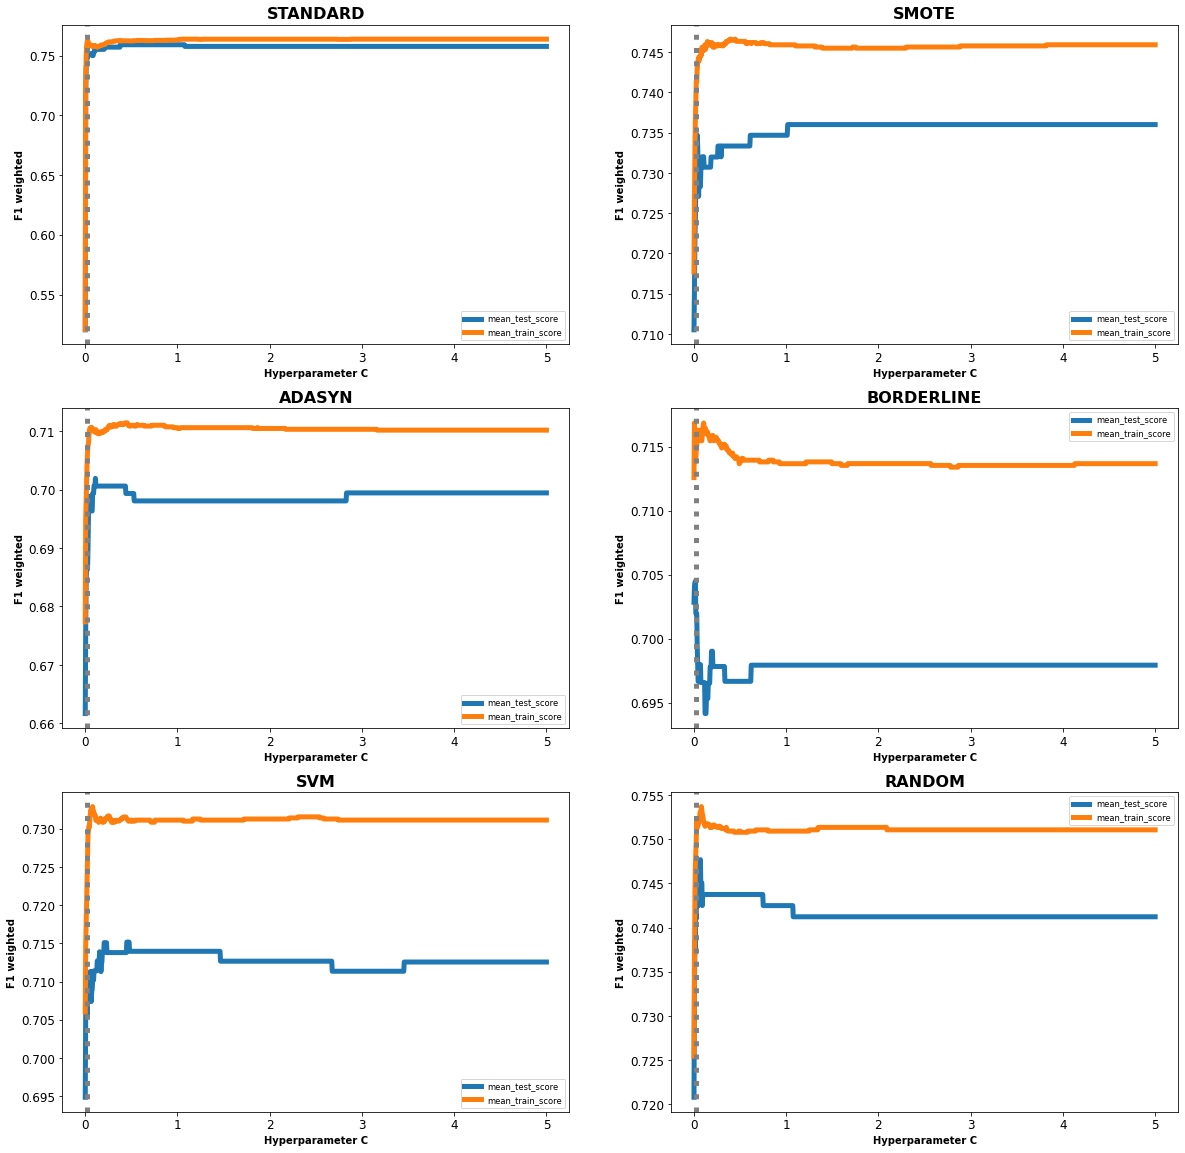

In [113]:
plt.rcParams['figure.figsize'] = [20, 20]

i = 1
for ovesampling_technique in data_to_train:

    plt.subplot(3, 2, i)
    name = ovesampling_technique[2]
    plot_logreg_hyper(df[df["oversampling_technique"]==name], name)
    i = i + 1

In [94]:
df.oversampling_technique.unique()

array(['standard', 'SMOTE', 'ADASYN', 'BORDERLINE', 'SVM'], dtype=object)

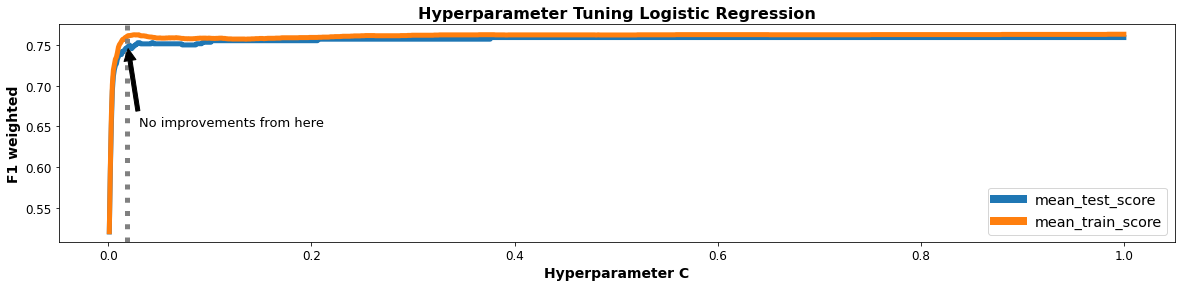

In [89]:
plot_logreg_hyper(df[df["oversampling_technique"]=="standard"])

In [ ]:
plt.savefig("sample.jpg", dpi=200)

In [13]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'split5_train_score', 'split6_train_score',
       'split7_train_score', 'split8_train_score', 'split9_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

#### 2.2.3  Make predictions in all Dataset

In [41]:
# Make Predictions in all dataset
y_hat = rfecv.predict(X_all)

# Save it in the df
df["Predicted_logreg"] = y_hat

#### 2.2.4  Save the model

In [42]:
with open('../models/pima/standard_scaler/logreg_rfecv.pkl','wb') as f:
    pkl.dump(rfecv,f)

## 2.3 Random Forest

#### 2.3.1  Create Grid for Hyperparameter Selection

In [15]:
data_to_train = [(X_ros, y_ros, "RANDOM")] 

# Initialize Random Forest
model = RandomForestClassifier(random_state= 1)

# Hyperparameter Space
grid = {"max_depth":[5,10,20],
        "n_estimators":[i for i in range(10,100,10)],
        "min_samples_leaf":[i for i in range(1,10)],
        "criterion":["gini","entropy"],
        "max_features":["auto","sqrt","log2"]}

# Training        
for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]
    print(name)
    path = "../../../results/pima/Training/random_forest_v2" + name + ".csv"

    random_search = RandomizedSearchCV(estimator= model,n_iter=300, param_distributions = grid, cv=10, scoring="f1_weighted", verbose=1, n_jobs= -1, return_train_score=1, random_state=1)

    random_search.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(random_search.cv_results_)
    df.to_csv(path)

    # Save Model
    rs_best = random_search.best_estimator_ # Best Model

    path = "../../../models/pima/random_forest_v2" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(rs_best,f)

    # Log
    try:
        y_pred = rs_best.predict(X_loop)
        train_error = f1_score(y_loop, y_pred, average="weighted")
        print("F1-weighted for: " + name)
        print("Training: " + str(train_error))
        print("Validation: " + str(random_search.best_score_))
    except:
        print(name + " process")

RANDOM
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: RANDOM
Training: 1.0
Validation: 0.8701809649222032


#### 2.3.4  Make predictions in whole dataset

In [12]:
y_hat = rf_best.predict(X_all)

# Save it in the df
df["Predicted_RandomForest"] = y_hat

#### 2.3.5  Save the model

In [13]:
with open('../models/pima/standard_scaler/random_forest.pkl','wb') as f:
    pkl.dump(rf_best,f)

## 2.4 Gradient Boosting

#### 2.4.1  Create Grid for Hyperparameter Selection

In [115]:
for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]

    path = "../../../results/pima/Training/stratified_standard_scaler/gradient_boosting_" + name + ".csv"

    gbc = GradientBoostingClassifier(random_state=1)

    param_grid = {
                'n_estimators' : [10, 20, 50],
                'learning_rate': [0.01, 0.075, 0.005],
                'max_depth': [1, 2, 3, 4, 5],#
                'min_samples_leaf': [1, 5, 10,20, 50, 70],#
                'min_samples_split': [20, 30, 50, 100, 150], #
                'max_features': [ 0.3, 0.2, 0.1] #
                }

    rs_gbc = RandomizedSearchCV(gbc, param_grid, cv=10, random_state=1,scoring="f1_weighted", verbose = 1, return_train_score=1, n_iter=100)

    rs_gbc.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(rs_gbc.cv_results_)
    df.to_csv(path)

    # Save Model
    gbc_best = rs_gbc.best_estimator_ # Best Model

    path = "../../../models/pima/stratified_standard_scaler/gradient_boosting" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(gbc_best,f)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


#### 2.4.2  Train

In [68]:
rs_gbc.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=1),
                   n_iter=50,
                   param_distributions={'learning_rate': [0.01, 0.075, 0.005],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'max_features': [0.3, 0.2, 0.1],
                                        'min_samples_leaf': [1, 5, 10, 20, 50,
                                                             70],
                                        'min_samples_split': [20, 30, 50, 100,
                                                              150],
                                        'n_estimators': [10, 20, 50]},
                   random_state=1, return_train_score=1, scoring='f1_weighted',
                   verbose=1)

In [69]:
# Best Model
gbc_best = rs_gbc.best_estimator_

# Best score
rs_gbc.best_score_

0.7583889232410196

In [70]:
from sklearn.metrics import f1_score

y_pred = gbc_best.predict(X_train)

f1_score(y_pred, y_train, pos_label="diabetes", average="weighted")

/home/raul/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1379: UserWarning: Note that pos_label (set to 'diabetes') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


0.8711877287273428

In [71]:
path = "../../../results/pima/Training/stratified_standard_scaler/gradient_boosting_standardscaler.csv"
df = pd.DataFrame(rs_gbc.cv_results_)
df.to_csv(path)

#### 2.4.4  Make predictions in all data

In [20]:
y_hat = gbc_best.predict(X_all)

# Save it in the df
df["Predicted_GradientBoosting"] = y_hat

#### 2.4.5  Save the model

In [74]:
path = "../../../models/pima/stratified_standard_scaler/gradient_boosting_standardscaler.pkl"
with open(path,'wb') as f:
    pkl.dump(gbc_best,f)

## 2.5 ADA Boosting

#### 2.5.1  Create Grid for Hyperparameter Selection

In [22]:
# Models and Base Estimator
dtc = DecisionTreeClassifier(random_state=1)
log_reg = LogisticRegression(random_state=1)

model = AdaBoostClassifier(random_state=1)

# Grid
grid = { "n_estimators": np.arange(10, 5000, 10),
                    "learning_rate": np.linspace(0.001, 1, 300),
                    "base_estimator":[dtc, log_reg],
                    "algorithm": ["SAMME", "SAMME.R"]
}

In [23]:
data_to_train = [(X_under, y_under, "UNDER")] 

In [24]:
for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]
    print(name)
    path = "..\\..\\..\\results\\pima\\Training\\stratified_standard_scaler\\ada_boost_" + name + ".csv"

    random_search = RandomizedSearchCV(estimator= model,n_iter=100, param_distributions = grid, cv=10, scoring="f1_weighted", verbose=1, n_jobs= -1, return_train_score=1, random_state=1)

    random_search.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(random_search.cv_results_)
    df.to_csv(path)

    # Save Model
    rs_best = random_search.best_estimator_ # Best Model

    path = "..\\..\\..\\models\\pima\\stratified_standard_scaler\\ada_boost_" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(rs_best,f)

    # Log
    try:
        y_pred = rs_best.predict(X_loop)
        train_error = f1_score(y_loop, y_pred, average="weighted")
        print("F1-weighted for: " + name)
        print("Training: " + str(train_error))
        print("Validation: " + str(random_search.best_score_))
    except:
        print(name + " process")

UNDER
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: UNDER
Training: 0.7449246835616065
Validation: 0.7274366737335516


#### 2.5.4  Make predictions in training and validation

In [27]:
y_hat = gs_ada_best.predict(X_all)

# Save it in the df
df["Predicted_AdaBoost"] = y_hat

#### 2.5.5  Save the model

In [28]:
with open('../models/pima/standard_scaler/ada_boosting.pkl','wb') as f:
    pkl.dump(gs_ada_best,f)

## 2.6 SVC

#### 2.6.1  Create Grid for Hyperparameter Selection

In [14]:
data_to_train = [(X_ros, y_ros, "RANDOM")] 

# Initialize Random Forest
model = SVC(probability=True)

grid = {'kernel': ['rbf'], 
        'gamma': [ 0.001, 0.01, 0.1, 1],
        'C': [1, 10, 50, 100, 200,300, 1000]}

# Training        
for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]
    print(name)
    path = "../../../results/pima/Training/svc_" + name + ".csv"

    random_search = GridSearchCV(estimator= model, param_grid = grid, cv=10, scoring="f1_weighted", verbose=1, n_jobs= -1, return_train_score=1)

    random_search.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(random_search.cv_results_)
    df.to_csv(path)

    # Save Model
    rs_best = random_search.best_estimator_ # Best Model

    path = "../../../models/pima/svc_" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(rs_best,f)

    # Log
    try:
        y_pred = rs_best.predict(X_loop)
        train_error = f1_score(y_loop, y_pred, average="weighted")
        print("F1-weighted for: " + name)
        print("Training: " + str(train_error))
        print("Validation: " + str(random_search.best_score_))
    except:
        print(name + " process")

RANDOM
Fitting 10 folds for each of 28 candidates, totalling 280 fits
F1-weighted for: RANDOM
Training: 1.0
Validation: 0.8505468070965746


#### 2.6.2  Train the model

In [31]:
gs_sv.fit(X_train, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 273 out of 280 | elapsed:   20.3s remaining:    0.5s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   20.9s finished


GridSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=4,
             param_grid={'C': [1, 10, 50, 100, 200, 300, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [32]:
# Best Model
sv_best = gs_sv.best_estimator_

# Best score
gs_sv.best_score_

0.7765897973445142

#### 2.6.3  Make predictions in training and validation

In [33]:
y_hat = sv_best.predict(X_all)

# Save it in the df
df["Predicted_SupportVectorClassifier"] = y_hat

#### 2.6.4  Save the model

In [34]:
with open('../models/pima/standard_scaler/svc.pkl','wb') as f:
    pkl.dump(sv_best,f)

## Save Final df

In [36]:
df.to_csv("../data/predictions/pima/standard_scaler/predictions_9june.csv")

## 2.7 Deep Learning 

I try to do a deep learning approach also because I really like Deep Learning. I even made the whole specialization of Deep Learning in Coursera (100 hours) and my master thesis was about classifying different Respiratory Sounds with DL.

However, there is a problem in the way I have to encode the data to feed it to the model. I did the one fitting, but the model was not learning anything. I put the code so you can evaluate that I can also use Keras and TensorFlow.

#### 2.7.1 Create the Model

In [12]:
# Create the model
input_dim = X_train.shape[1]

model = Sequential(
    [
        Dense(256, activation="relu", input_shape=(input_dim,)),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(2, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               12288     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 514       
Total params: 144,386
Trainable params: 144,386
Non-trainable params: 0
________________________________________________

In [13]:
optimizer = Adam(lr=0.000001)
auc = tf.keras.metrics.AUC()
metrics = ['accuracy', auc] 
loss_function = 'binary_crossentropy'

# Compile model
model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

#### 2.7.2 Train the model

In [14]:
# Establishing Callbacks
csv_logger = CSVLogger("../models/deep_learning/history.csv", append=True) 
checkpoint = ModelCheckpoint("../models/deep_learning/dl_model.h5", monitor='val_auc_1', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') 
early_stopping = EarlyStopping(monitor='val_auc', min_delta=0, patience=20, verbose=1, mode='auto')

In [6]:
epochs = 500 # Number of epochs to train (We put this number high, because we have the early stopping callback)
model.fit(X_train, y_train, validation_data = (X_val, y_val), callbacks = [csv_logger, checkpoint, early_stopping], epochs=epochs)

#### 2.7.3 Evaluate the Training

In [16]:
input_file = "../models/deep_learning/history.csv"
history = pd.read_csv(input_file)

# Tidy the df so it become easier to plot
history['epoch'] = history.index
history = pd.melt(history, id_vars=['epoch'])
history.rename(columns={"variable":"metric"},inplace=True)

Text(0.5, 1.0, 'Loss Plot')

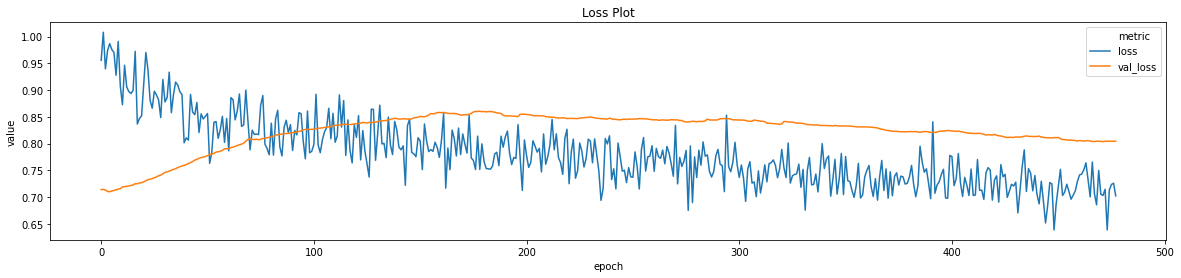

In [18]:
# Loss Plot
loss_df = history[history['metric'].isin(['val_loss','loss'])]
sns.lineplot(x='epoch', y='value', hue='metric', data=loss_df)
plt.title("Loss Plot")

-The value of val_loss and loss is increasing while it must decrease that why I said it is not learning. The same happens with accuracy and auc, they remain flat

## Xgboost

In [11]:
import xgboost as xgb
from hyperopt import hp
from sklearn.preprocessing import LabelEncoder

In [12]:
# Initiate Label Encoder
le = LabelEncoder()

# Model
model = xgb.XGBClassifier()

# Ggrid
grid=params = {
    "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}


# Train
for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]
    print(name)
    path = "../../../results/pima/Training/xgboost_" + name + ".csv"

    # Converting y_loop so it can be fit by XGB
    y_loop = le.fit_transform(y_loop)

    random_search = RandomizedSearchCV(estimator= model,n_iter=300, param_distributions = grid, cv=10, scoring="f1_weighted", verbose=1, n_jobs= -1, return_train_score=1, random_state=1)

    random_search.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(random_search.cv_results_)
    df.to_csv(path)

    # Save Model
    rs_best = random_search.best_estimator_ # Best Model

    path = "../../../models/pima/xgboost_" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(rs_best,f)

    # Log
    try:
        y_pred = rs_best.predict(X_loop)
        train_error = f1_score(y_loop, y_pred, average="weighted")
        print("F1-weighted for: " + name)
        print("Training: " + str(train_error))
        print("Validation: " + str(random_search.best_score_))
    except:
        print(name + " process")

STANDARD
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: STANDARD
Training: 0.9983704450481075
Validation: 0.7808560019263068
SMOTE
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: SMOTE
Training: 1.0
Validation: 0.8435070389978089
ADASYN
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: ADASYN
Training: 1.0
Validation: 0.8406772448958153
BORDERLINE
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: BORDERLINE
Training: 1.0
Validation: 0.8414097694704298
SVM
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: SVM
Training: 1.0
Validation: 0.8276745451610926
RANDOM
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: RANDOM
Training: 1.0
Validation: 0.8754532199487963
UNDER
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: UNDER
Training: 0.8387771256994678
Validation: 